### HW recap and setup

We will train Random Forest classifier and Gradient Boosting classifier for MNIST.

Use the seed 0 everywhere.

1. Import MNIST data as we did in Lecture 7. We are only going to use digit 0 and digit 1. So extract only those examples and discard the rest.

Next, randomly split the data into 80% training data and 20% testing data. Then split the training data again into 75% training data and 25% validation data. Keep this split fixed throughout the experiments.

2. Use the validation set to choose the optimal hyperparameters "n_estimators" and "max_depth" for Random Forest, and report the best hyperparameters and the best validation error. The suggested hyperparameter values are

    - ns_estimators = [10,20,50,100,200]
    - max_depths = [1,2,5,10,20]

3. Train Random Forest again with all data (i.e., training + validation data). Report the training and the test error.

4. Plot the feature importance as an image, as we did in Lecture 7.

5. Repeat 2 with Gradient Boosting.

6. Repeat 3 with Gradient Boosting

7. Repeat 4 with Gradient Boosting.

In [1]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

Reading the data

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
Y = mnist["target"] 

### 1. Import MNIST data. We are only going to use digit 0 and digit 1. Next, randomly split the data into 80% training and 20% testing... and split the training into 75% train and 25% validation data...


Again, I'm stealing the code from class to plot the digits data base

In [3]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1 

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Now let's make sure we know how to extract the 0's and 1's correctly

[0 1 1 1 1 0 1 1 0 0]
[1 0 0 1 0 1 0 0 1 1]
[0 1 1 0 0 0 1 1 1 1]
[0 1 1 0 0 0 0 1 1 1]
[1 0 0 1 1 1 0 1 1 1]


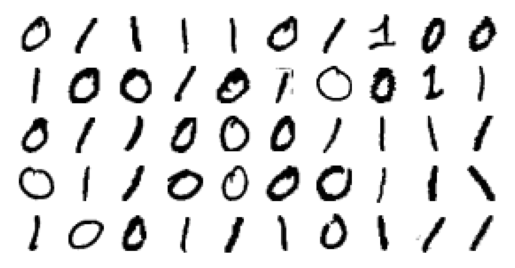

In [4]:
# mask of the 0's and 1's
mask_0_1 = ((Y==0) | (Y==1))
Y = Y[mask_0_1]
X = X[mask_0_1]
# let's check the first 50
for i in range(5):
    print(Y[i*10:i*10+10])
plot_digits(X[0:50])


That looks good. Now let's do the spliting. Same as previous HW, create a permutation and then take the first 80% and then further split into 60% (75%) and 20% (25%)

In [5]:
m = len(Y)
np.random.seed(0)

# create a random index permutation
ind =np.array(range(0,m))
ind = np.random.permutation(ind)

# see some random indices
print(ind[0:20])

[ 9612  4447  8936  4006 13853  8900  5939  6204 10640  2192 11142 13199
  7327  1875 13076 11159  7186  3673 14488   214]


In [6]:
# indices for 60% training, 20% validation , 20% test
v_split = int(m*0.8)
t_split = int(m*0.6)
train_ind = ind[0:t_split]
valid_ind = ind[t_split:v_split]
test_ind = ind[v_split:m]

### 2. Use the validation set to choose the optimal hyperparameters "n_estimators" and "max_depth" for Random Forest, and report the best hyperparameters and the best validation error.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

ns_estimators = [10,20,50,100,200]
max_depths = [1,2,5,10,20]
v_accuracy = []
# for each combination of parameters
for n in ns_estimators:
    temp_accu = []
    for depth in max_depths:
        # I don't feel confortable using the same random seed here... but it's hw right?
        forest_clf = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=0)
        # fit on training
        forest_clf.fit(X = X[train_ind], y = Y[train_ind])
        # predict on validation set
        y_pred = forest_clf.predict(X[valid_ind])
        # store accuracy
        temp_accu.append( accuracy_score(Y[valid_ind], y_pred) )
    v_accuracy.append(temp_accu)
v_accuracy = np.array(v_accuracy)

Now let's see who did best (reusing my code from before)

In [8]:
import seaborn as sns
import numpy as np

def plot_2D_parameter_space_errors(
        error_matrix=np.array([]),
        title = "errors",
        xlabel = "",
        ylabel = "",
        x_ticks = [""],
        y_ticks = [""],
        cmap = "flare_r",
        annot = True,
        fmt = ".3f",
        min = True,
        index = True
        ):
    # plotting
    plt.figure()
    sns.heatmap(
    error_matrix,
    xticklabels=x_ticks,
    yticklabels=y_ticks,
    cmap=cmap,
    annot=annot,
    fmt=fmt
    )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # finding the min/max index
    if index:
        ind_1D = np.argmin(error_matrix) if min else np.argmax(error_matrix)
        return np.unravel_index(ind_1D,error_matrix.shape)


(1, 3)


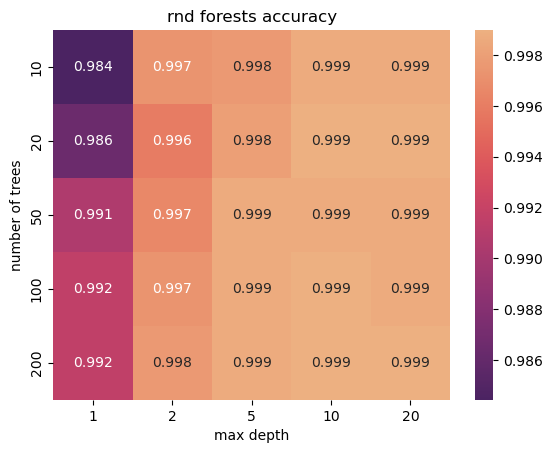

In [9]:
max_ind = plot_2D_parameter_space_errors(
    error_matrix=v_accuracy,
    title="rnd forests accuracy",
    ylabel="number of trees",
    xlabel="max depth",
    y_ticks=ns_estimators,
    x_ticks=max_depths,
    min=False
    )
print(max_ind)

We can see from this that there is a set of different combinations that yield 99.9% accuracy. I pick 20 trees and a max depth of 10 since we want to reduce overfitting and this match nicely with the argmax function.

In [10]:
n_best = ns_estimators[max_ind[0]]
depth_best = max_depths[max_ind[1]]
print("n=",n_best)
print("depth=",depth_best)

n= 20
depth= 10


### 3. Train Random Forest again with all data (i.e., training + validation data). Report the training and the test error.

I will use the best parameters from before

In [11]:
full_train_ind = np.concatenate((train_ind,valid_ind)) 
# best parameters forest
forest_clf = RandomForestClassifier(n_estimators=n_best, max_depth=depth_best, random_state=0)

# fit on training and get accuracy on training set
forest_clf.fit(X = X[full_train_ind], y = Y[full_train_ind])
y_train_predict = forest_clf.predict(X[full_train_ind])
train_acc = accuracy_score(Y[full_train_ind],y_train_predict)
print("train accuracy", train_acc)
# predict and accuracy on test set
y_test_predict = forest_clf.predict(X[test_ind])
test_acc = accuracy_score(Y[test_ind],y_test_predict)
print("test accuracy", test_acc)

train accuracy 1.0
test accuracy 0.9996617050067659


From where we see that the train accuracy is 100% and the test accuracy is 99.96%.

### 4. Plot the feature importance as an image, as we did in Lecture 7.

Copying some of the code from class for the plotting and stuff

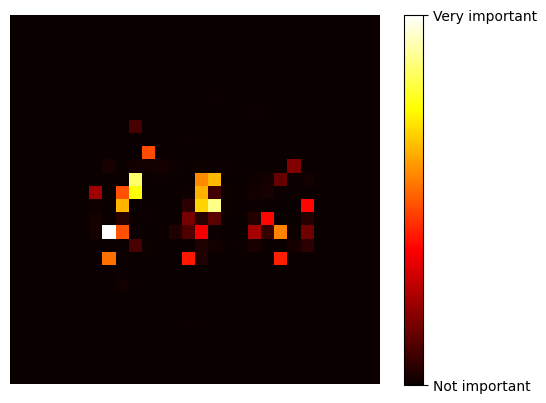

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(forest_clf.feature_importances_)

cbar = plt.colorbar(ticks=[forest_clf.feature_importances_.min(), forest_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

And we can kinda see how that makes sense as the pixels in the middle help distinguish the 1's and the pixels on the sides help distinguish the 0's.

### 5. Repeat 2 with Gradient Boosting.

Now let's rinse and repeat. 

Edit: this was taking too long to run so I time it to get an idea of how long it would take. I learned that increasing on a scale of 2 on either parameter roughly duplicate the time, and since adding powers of 2 gives the next power of 2 then the time it takes was roughly $2^{m+1}2^{n+1}$.

Since my patience doesn't go beyond 5 min I estimated a bound for the exponent 

$$
m+n+2=\log_2(5*60)\approx 8.22\quad \Longrightarrow \quad m+n=6
$$

and so I reduced my parameter space to only 3 different parameters on each space

Edit: after running it it seemed that it managed to run for a little over a minute so I can tolerate 4 times that and so I increased each parameter by 1 more.

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import timeit

ns_estimators = [10,20,50,100]
max_depths = [1,2,5,10]
v_accuracy = []
# for each combination of parameters
for n in ns_estimators:
    print("n=", n)
    temp_accu = []
    for depth in max_depths:
        print("   depth=",depth)
        t0 = timeit.default_timer()
        # I'm timing it because I got tired of waiting
        gradient_clf = GradientBoostingClassifier(n_estimators=n, max_depth=depth, random_state=0)
        # fit on training
        gradient_clf.fit(X = X[train_ind], y = Y[train_ind])
        # predict on validation set
        y_pred = gradient_clf.predict(X[valid_ind])
        # print time it took
        time = timeit.default_timer()-t0
        print("   ",int(round(time/60,0)),":",int(round(time%60,0)))
        # store accuracy
        temp_accu.append( accuracy_score(Y[valid_ind], y_pred) )
    v_accuracy.append(temp_accu)
v_accuracy = np.array(v_accuracy)

n= 10
   depth= 1
    0 : 4
   depth= 2
    0 : 6
   depth= 5
    0 : 13
   depth= 10
    0 : 22
n= 20
   depth= 1
    0 : 6
   depth= 2
    0 : 11
   depth= 5
    0 : 25
   depth= 10
    1 : 42
n= 50
   depth= 1
    0 : 16
   depth= 2
    0 : 18
   depth= 5
    1 : 41
   depth= 10
    1 : 20
n= 100
   depth= 1
    0 : 20
   depth= 2
    1 : 42
   depth= 5
    2 : 35
   depth= 10
    3 : 38


Not so bad, 8 min. Now let's see who did best

(3, 0)


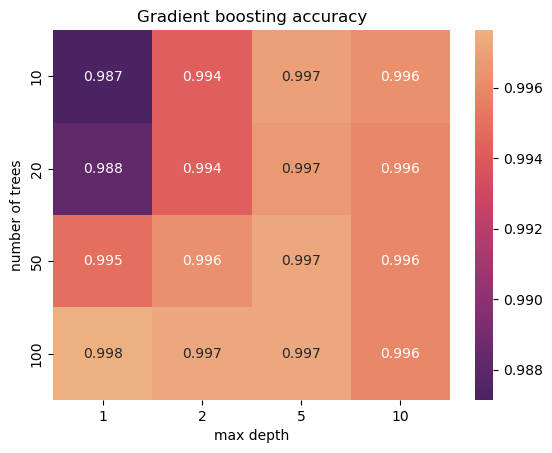

In [14]:
max_ind = plot_2D_parameter_space_errors(
    error_matrix=v_accuracy,
    title="Gradient boosting accuracy",
    ylabel="number of trees",
    xlabel="max depth",
    y_ticks=ns_estimators,
    x_ticks=max_depths,
    min=False
    )
print(max_ind)

The best result happens with 100 trees and max depth of 1

In [15]:
n_best = ns_estimators[max_ind[0]]
depth_best = max_depths[max_ind[1]]
print("n=",n_best)
print("depth=",depth_best)

n= 100
depth= 1


### 6. Repeat 3 with Gradient Boosting

and once more...

In [16]:
full_train_ind = np.concatenate((train_ind,valid_ind)) 
# best parameters forest
gradient_clf = RandomForestClassifier(n_estimators=n_best, max_depth=depth_best, random_state=0)

# fit on training and get accuracy on training set
gradient_clf.fit(X = X[full_train_ind], y = Y[full_train_ind])
y_train_predict = gradient_clf.predict(X[full_train_ind])
train_acc = accuracy_score(Y[full_train_ind],y_train_predict)
print("train accuracy", train_acc)
# predict and accuracy on test set
y_test_predict = gradient_clf.predict(X[test_ind])
test_acc = accuracy_score(Y[test_ind],y_test_predict)
print("test accuracy", test_acc)

train accuracy 0.9925575101488497
test accuracy 0.9956021650879567


From where we see that the train accuracy is 99.25% and the test accuracy is 99.56%.

### 7. Repeat 4 with Gradient Boosting

and more...

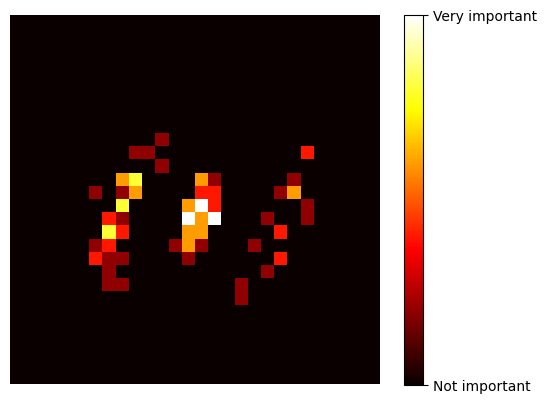

In [17]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(gradient_clf.feature_importances_)

cbar = plt.colorbar(ticks=[gradient_clf.feature_importances_.min(), gradient_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

plt.show()

And we get similar results; middle pixels help distinguish the 1's and the sides help distinguish the 0's.